**Waste Segregation using CNN**

In [1]:
# ---------- Library Imports ----------
# Import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Mount my Google Drive to get the data
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
from IPython.display import Image

import pandas as pd
import torch.utils.data as data_utils

Mounted at /content/drive


In [ ]:
# ---------- UNZIP THE DATA - No need to run this again ----------
# Unzips the file and extracts data
#!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset'

The number of images in the training dataset is:  9197
The number of images in the validation dataset is:  3083
The number of images in the validation dataset is:  3084


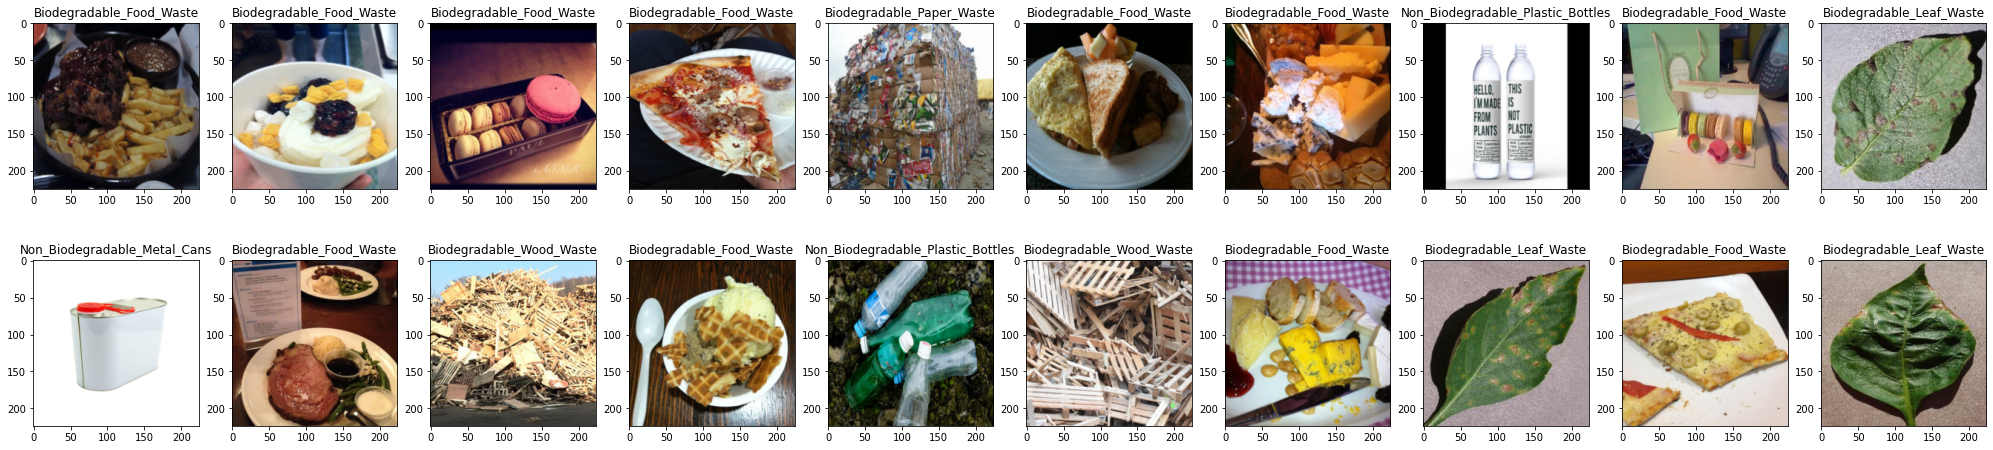

In [12]:
# ---------- Process the data and ensure it successfully loads ----------

# Transform the data
transform_data = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Get the training and validation data
#train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Year 4/APS360/Project /Our_Split_Dataset/Training', transform=transform_data)
#val_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Year 4/APS360/Project /Our_Split_Dataset/Validation', transform=transform_data)

train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Training', transform=transform_data)
val_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Validation', transform=transform_data)
test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Testing', transform=transform_data)

'''indices = torch.arange(5000)
train_data = data_utils.Subset(train_data, indices)'''

# Print the length of each set to verify with our manual cleansing
print('The number of images in the training dataset is: ', len(train_data))
print('The number of images in the validation dataset is: ', len(val_data))
print('The number of images in the validation dataset is: ', len(test_data))

# Load some of the train data just to verify the data is actually loaded
# Select an arbitrary batch size for sanity check sake
train_load = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
images, labels = iter(train_load).next()
images = images.numpy() 

# Folder names
folder = ['Biodegradable_Food_Waste', 
           'Biodegradable_Leaf_Waste', 
           'Biodegradable_Paper_Waste', 
           'Biodegradable_Wood_Waste', 
           'Non_Biodegradable_Electronic_Waste', 
           'Non_Biodegradable_Metal_Cans', 
           'Non_Biodegradable_Plastic_Bags', 
           'Non_Biodegradable_Plastic_Bottles']

# Plot the images
figure = plt.figure(figsize=(35, 8))
for i in np.arange(20):
    ax = figure.add_subplot(2, 10, i+1)
    ax.set_title(folder[labels[i]])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

folder = ['Biodegradable_Food_Waste']

In [ ]:
# ---------- Accuracy and Train code from Tutorial 3 ----------

# Accuracy function
def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    class0, class1, class2, class3, class4, class5, class6, class7 = 0,0,0,0,0,0,0,0
    for images, labels in iter(data_loader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()

      output = model(images)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
      total += images.shape[0]

    class_list = [class0, class1, class2, class3, class4, class5, class6, class7]
    print(class_list)
    return correct/total

# Train function
def train(model, train_data, validation_data, batch_size=64, epochs=1, learning_rate=0.01):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

  torch.manual_seed(50) 

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  iters, losses, train_acc, val_acc = 0, [], [], []

  # Adding for csv file
  df = pd.DataFrame(columns=['epoch','train_accuracy', 'validation_accuracy'])

  for epoch in range(epochs):
    for images, labels in iter(train_loader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()

      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters += 1

    train_acc.append(get_accuracy(model, train_loader))
    val_acc.append(get_accuracy(model, validation_loader))
    losses.append(float(loss)/batch_size)
    print('Epoch: ', epoch, 'Training Accuracy: ', train_acc[-1], 'Validation Accuracy: ', val_acc[-1])

    #Saving model after each model to get history 
    model_save_name = 'Waste_Classification_AlexNet_' + str(epoch) + '.pt'
    path = F"/content/drive/MyDrive/Colab Notebooks/APS360/Project/{model_save_name}" 
    torch.save(myAlexNetCNN.state_dict(), path)

    # Saving acc values after each epoch 
    df.append([{'epoch':epoch}, {'train_accuracy':train_acc[-1]}, {'validation_accuracy':val_acc[-1]}])
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/APS360/Project/acc_datapoints.csv')

  # Plot the graphs
  # Accuracy Plot
  plt.title("Training Curve")
  plt.plot(train_acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Loss Plot
  plt.title('Training Curve')
  plt.plot(losses, label='Training')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()

In [5]:
# ---------- Create CNN Model ----------
class Waste_Classification_CNN(nn.Module):
    def __init__(self):
        super(Waste_Classification_CNN, self).__init__()
        self.name = "Waste_Classification_CNN"
        # Input channel = 3, output channel = 32, kernel size = 3, stride = padding = 1
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        # Input channel = 32, output channel = 64, kernel size = 3, stride = padding = 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        # Input channel = 64, output channel = 128, kernel size = 3, stride = padding = 1
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        # Kernel size and stride are both 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

first_model = Waste_Classification_CNN()


'''if torch.cuda.is_available():
  first_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')

train(first_model, train_data, val_data, batch_size=50, epochs=5, learning_rate=0.01)'''

"if torch.cuda.is_available():\n  first_model.cuda()\n  print('We are utilizing the GPU')\nelse:\n  print('We are not utilizing the GPU')\n\ntrain(first_model, train_data, val_data, batch_size=50, epochs=5, learning_rate=0.01)"

In [ ]:
first_model = Waste_Classification_CNN()

if torch.cuda.is_available():
  first_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')

train(first_model, train_data, val_data, batch_size=50, epochs=25, learning_rate=0.03)

model_save_name = 'Waste_Classification_CNN.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/APS360/Project/{model_save_name}" 
torch.save(first_model.state_dict(), path)

NameError: ignored

In [6]:
if torch.cuda.is_available():
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')

model_save_name = 'Waste_Classification_CNN_15epoch_run.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/APS360/Project/{model_save_name}" 
first_model.load_state_dict(torch.load(path))

We are utilizing the GPU


<All keys matched successfully>

In [ ]:
test_load = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
print(get_accuracy(first_model, test_load))

0.8823529411764706


In [ ]:
#first_model = Waste_Classification_CNN()

#if torch.cuda.is_available():
#  first_model.cuda()
#  print('We are utilizing the GPU')
#else:
#  print('We are not utilizing the GPU')

#train(first_model, train_data, val_data, batch_size=64, epochs=5, learning_rate=0.03)

In [ ]:
#first_model = Waste_Classification_CNN()

#if torch.cuda.is_available():
#  first_model.cuda()
#  print('We are utilizing the GPU')
#else:
#  print('We are not utilizing the GPU')

#train(first_model, train_data, val_data, batch_size=32, epochs=5, learning_rate=0.03)

In [ ]:
# ---------- Create Pretrained AlexNet Model ----------
# Define path to data
path = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset'

batch_size = 1
num_workers = 1

test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Testing', transform=transform_data)

train_data_load = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_data_load = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#test_data_load = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# Store the features to folders as tensors
i = 0
for images, labels in train_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folderName = path + '/Training/' + str(folder[labels])
  if not os.path.isdir(folderName):
    os.mkdir(folderName)
  torch.save(featuresTensor.squeeze(0), folderName + '/' + str(i) + '.tensor')
  i += 1

i = 0
for images, labels in val_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folderName = path + '/Validation/' + str(folder[labels])
  if not os.path.isdir(folderName):
    os.mkdir(folderName)
  torch.save(featuresTensor.squeeze(0), folderName + '/' + str(i) + '.tensor')
  i += 1

'''i = 0
for images, labels in test_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folderName = path + '/Testing/' + str(folder[labels])
  if not os.path.isdir(folderName):
    os.mkdir(folderName)
  torch.save(featuresTensor.squeeze(0), folderName + '/' + str(i) + '.tensor')
  i += 1'''

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


OSError: ignored

In [ ]:
# Set up the features
path = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset'
train_features = torchvision.datasets.DatasetFolder(path + '/Training', loader=torch.load, extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder(path + '/Validation', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(path + '/AlexNet_Testing', loader=torch.load, extensions=('.tensor'))

# Set up the data loader
batch_size = 32
num_workers = 1

train_feature_load = torch.utils.data.DataLoader(train_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_feature_load = torch.utils.data.DataLoader(val_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_feature_load = torch.utils.data.DataLoader(test_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)

#Verify the features
dataIterator = iter(train_feature_load)
features, labels = dataIterator.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Testing', transform=transform_data)

In [ ]:
from math import floor

torch.manual_seed(5)

#The design choices for my AlexNet CNN model  will be explained after the code
class AlexNetModel(nn.Module):
  def __init__(self, name = "AlexNet_Model"):
    super(AlexNetModel, self).__init__()
    #Input channels = 256, Output channels = 512, Kernel size = 3
    self.conv1 = nn.Conv2d(256, 512, 3)
    #Kernel size = 2, Stride = 2
    self.pool = nn.MaxPool2d(2, 2)

    #Calculate the correct input size for the fully connected layer
    self.var = floor((6 - 3 + 1)/2)
    self.fullyConnectedInput = self.var * self.var * 512

    #Input channels = self.var * self.var * 512, Output channels = 35
    self.fc1 = nn.Linear(self.fullyConnectedInput, 35)
    #Input channels = 35, Output channels = 8
    self.fc2 = nn.Linear(35, 8)

  def forward(self, features):
    #ReLU Activation layer
    var = self.pool(F.relu(self.conv1(features)))
    #Flatten the tensor
    var = var.view(-1, self.fullyConnectedInput)
    #ReLU Activation layer
    var = F.relu(self.fc1(var))
    #Fully Connected Layer 
    var = self.fc2(var)
    #Softmax function
    return F.softmax(var, dim=1)

Using CUDA!
Epoch:  0 Training Accuracy:  0.3076923076923077 Validation Accuracy:  0.8181818181818182
Epoch:  1 Training Accuracy:  0.8461538461538461 Validation Accuracy:  0.6363636363636364
Epoch:  2 Training Accuracy:  0.6153846153846154 Validation Accuracy:  0.8181818181818182
Epoch:  3 Training Accuracy:  0.9230769230769231 Validation Accuracy:  0.5454545454545454
Epoch:  4 Training Accuracy:  0.6923076923076923 Validation Accuracy:  0.7272727272727273
Epoch:  5 Training Accuracy:  0.8461538461538461 Validation Accuracy:  0.8181818181818182
Epoch:  6 Training Accuracy:  0.5384615384615384 Validation Accuracy:  0.7272727272727273
Epoch:  7 Training Accuracy:  0.7692307692307693 Validation Accuracy:  0.7272727272727273
Epoch:  8 Training Accuracy:  0.6923076923076923 Validation Accuracy:  1.0
Epoch:  9 Training Accuracy:  0.8461538461538461 Validation Accuracy:  0.7272727272727273
Epoch:  10 Training Accuracy:  0.8461538461538461 Validation Accuracy:  0.8181818181818182
Epoch:  11 T

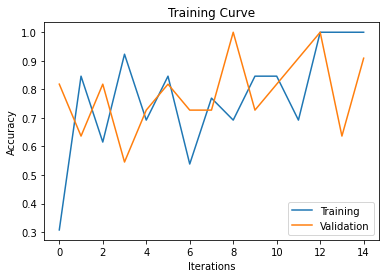

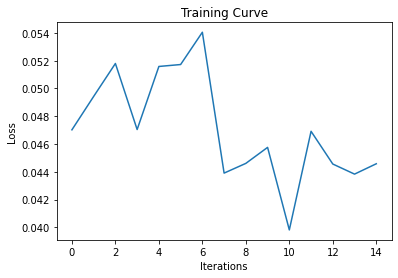

In [ ]:
myAlexNetCNN = AlexNetModel()

if torch.cuda.is_available():
  print('Using CUDA!')

# Train the AlexNet CNN Model 
train(myAlexNetCNN, train_features, val_features, batch_size=32, epochs=15, learning_rate=0.01)

In [ ]:
if torch.cuda.is_available():
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')

myAlexNetCNN = AlexNetModel()
model_save_name = 'Waste_Classification_AlexNet_15epoch_run.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/APS360/Project/{model_save_name}" 
myAlexNetCNN.load_state_dict(torch.load(path))

We are utilizing the GPU


<All keys matched successfully>

In [ ]:
# Define path to data
path = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset'

batch_size = 1
num_workers = 1

test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Testing', transform=transform_data)

test_data_load = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

i = 0
for images, labels in test_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folderName = path + '/Testing/' + str(folder[labels])
  if not os.path.isdir(folderName):
    os.mkdir(folderName)
  torch.save(featuresTensor.squeeze(0), folderName + '/' + str(i) + '.tensor')
  i += 1

In [ ]:
print(get_accuracy(myAlexNetCNN))

[76, 4, 12, 5, 0, 0, 0, 0]
0.8667315175097277


In [18]:
# Accuracy function
def get_unit_accuracy(model, data_loader):
    correct = 0
    total = 0

    count = 0
    print(iter(data_loader))
    for images, labels in iter(data_loader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()

        output = model(images)
        prediction = output.max(1, keepdim = True)[1]
        if prediction[0][0] == 0:
          print("This is an example of: Biodegradable Food Waste. It belongs in the Compost, ie. your green bin. Thank you.")
        elif prediction[0][0] == 1:
          print("This is an example of: Biodegradable Leaf Waste. It belongs in Yard Waste. Thank you.")
        elif prediction[0][0] == 2:
          print("This is an example of: Biodegradable Paper Waste. It belongs in the Fibres bin. Thank you.")
        elif prediction[0][0] == 3:
          print("This is an example of: Biodegradable Wood Waste. It is unknown per our model. Thank you.")
        elif prediction[0][0] == 4:
          print("This is an example of: Non Biodegradable Electronic Waste. It is unknown per our model. Thank you.")
        elif prediction[0][0] == 5:
          print("This is an example of: Non Biodegradable Metal Cans. It belongs in the Containers bin. Thank you.")
        elif prediction[0][0] == 6:
          print("This is an example of: Non Biodegradable Plastic Bags. It belongs in the Garbage, ie. your grey bin. Thank you.")
        elif prediction[0][0] == 7:
          print("This is an example of: Non Biodegradable Plastic Bottles. It belongs in the Containers bin. Thank you.")
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        total += images.shape[0]
      return correct/total  

In [35]:
# ---------- Create CNN Model ----------
class Waste_Classification_CNN(nn.Module):
    def __init__(self):
        super(Waste_Classification_CNN, self).__init__()
        self.name = "Waste_Classification_CNN"
        # Input channel = 3, output channel = 32, kernel size = 3, stride = padding = 1
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        # Input channel = 32, output channel = 64, kernel size = 3, stride = padding = 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        # Input channel = 64, output channel = 128, kernel size = 3, stride = padding = 1
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        # Kernel size and stride are both 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

first_model = Waste_Classification_CNN()

In [36]:
if torch.cuda.is_available():
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')

model_save_name = 'Waste_Classification_CNN_15epoch_run.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/APS360/Project/{model_save_name}" 
first_model.load_state_dict(torch.load(path))

We are utilizing the GPU


<All keys matched successfully>

This is an example of: Biodegradable Food Waste. It belongs in the Compost, ie. your green bin. Thank you.
1.0


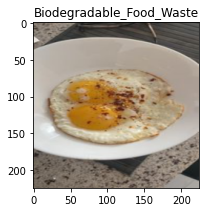

In [37]:
unit_test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/Project/Our_Split_Dataset/Unit_Test', transform=transform_data)
unit_test_data_load = torch.utils.data.DataLoader(unit_test_data, batch_size=2, num_workers=1, shuffle=False)

images, labels = iter(unit_test_data_load).next()
images = images.numpy() 

# Plot the image
figure = plt.figure(figsize=(35, 8))
for i in np.arange(20):
    ax = figure.add_subplot(2, 10, i+1)
    ax.set_title(folder[labels[i]])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    if i == 0:
      break

print(get_unit_accuracy(first_model, unit_test_data_load))